In [1]:
import cfinversion
from cfinversion.tools import lre
from cfinversion.distributions import *
import numpy as np

In [2]:
#setting svg-backend
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
#font shenanigans
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
# color-blind safe colormaps
from tol_colors import tol_cmap, tol_cset

In [4]:
from cfinversion.continuous import *
def fit_methods(cf, N = 10000, delta=10e-3, trunc = None):
  trunc = trunc or N * delta
  methods = {
            'Bohman A' : BohmanA(N=N,delta=delta),
            'Bohman B' : BohmanB(N=N,delta=delta),
            'Bohman C' : BohmanC(N=N,delta=delta),
            'Bohman D' : BohmanD(N=N,delta=delta, K = 4), 
            'Bohman E' : BohmanE(N=N,delta=delta, K = 8),
            'Naive Integral' : NaiveGPInverter(N = int(N*delta), delta = delta, num_points = 2*N),
            'DFT approxim.'  : FFTInverter(N=N, A = -trunc, B = trunc)
            }
  for method in methods:
    methods[method].fit(cf)
  return methods

def run_tests(cases):
  results = {}
  for case in cases: 
    results[case['name']] = fit_methods(case['dist'].chr, **case['test_arg'])
  return results

def compute_metrics(cases, results):
  metrics = {}
  for case in cases: 
    metrics[case['name']] = {}
    for m, estim in results[case['name']].items():
      metrics[case['name']][m] = compute_case_metrics(case['dist'], estim, case['test_pts'], tol_diff=1e-5 if m[:-2] == "Bohman" else None)      
  return metrics 
  
def compute_case_metrics(dist, estimated, x, tol_diff=None):
  metrics = {}    
  metrics['lre_errors_pdf'] = lre(dist.pdf(x), estimated.pdf(x))
  metrics['lre_errors_cdf'] = lre(dist.cdf(x), estimated.cdf(x))
  return metrics

# Distribution validations

## Examples:
1. Normal(0, 1)
2. Laplace(0, 1)
3. Uniform(0, 1)
4. Uniform^2(0,1)

In [5]:
epsilon = 0.01
x_sym = np.linspace(-2, 2, 500)
x_pos = np.linspace(0 + epsilon, 1 - epsilon, 500)
n = 100000
d = 1e-2
t = np.pi / (2 * d)
cases = [{
    "name"      : "Normal",
    "dist"      : Norm(0, 1),
    "test_pts"  : x_sym,
    "test_arg"  : {"N": n, "delta" : d, "trunc" : t} 
  },{
    "name"      : "Laplace",
    "dist"      : Laplace(0, 1),
    "test_pts"  : x_sym,
    "test_arg"  : {"N": n, "delta" : d, "trunc" : t} 
  },{
    "name"      : "Uniform",
    "dist"      : Uniform(0, 1),
    "test_pts"  : x_pos,
    "test_arg"  : {"N": n, "delta" : d, "trunc" : t} 
  },{
    "name"      : "UniformSquared",
    "dist"      : UniformSquared(0, 1),
    "test_pts"  : x_pos,
    "test_arg"  : {"N": n, "delta" : d, "trunc" : t}
  }
]
results = run_tests(cases)
metrics = compute_metrics(cases, results)
methods = list(results['Normal'].keys())

In [6]:
def plot_result(case_name, metrics, methods, ax, title = "", ft = "pdf", color = "lightblue"):
  lre_errs = []
  lre_labels = []
  for method in methods:
    lre_errs.append(metrics[case_name][method][f'lre_errors_{ft}'])
    lre_labels.append(method)
  bplot = ax.boxplot(lre_errs, patch_artist=True, tick_labels=lre_labels,
                      flierprops={'marker': 'o', 'markersize': 3},
                      medianprops={'color':'black'}, orientation='horizontal')
  for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(color)
  ax.grid()
  ax.set_xlabel(f'NLRE ({ft.upper()})')
  #ax.set_title(r'Разброс значений LRE для ' + ft.upper() + ' распределения ' + title)

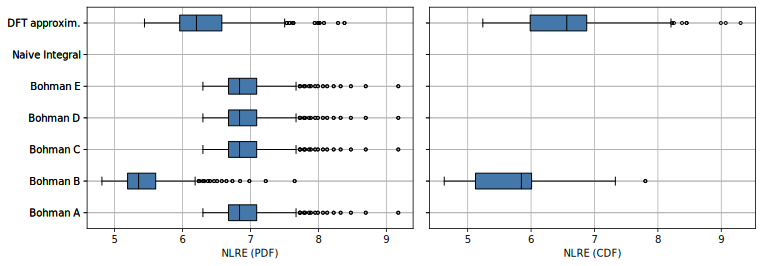

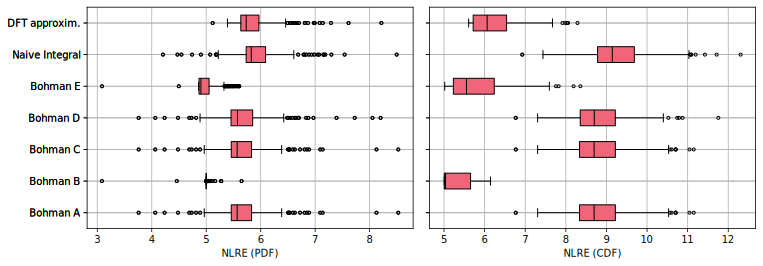

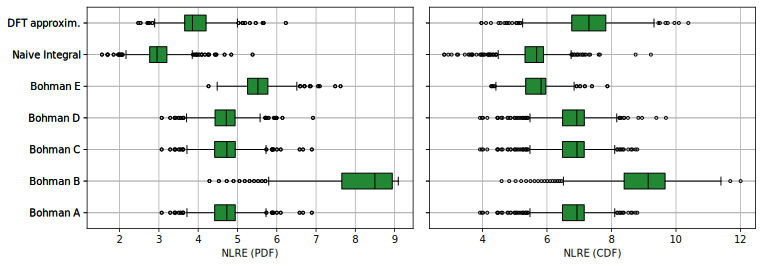

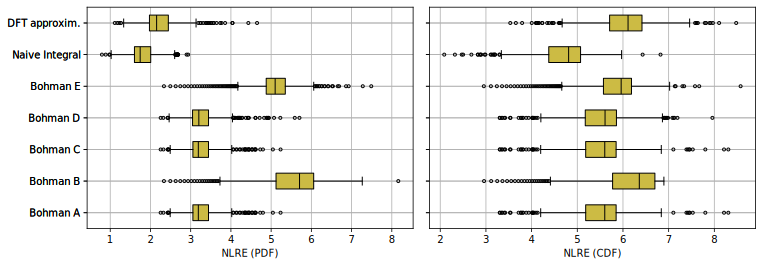

In [8]:
cmap = tol_cset('bright')
titles = [r"\$\mathcal{N}(0,1)\$"], r"\$\mathrm{Laplace}(0,1)\$", r"\$U(0,1)\$", r"\$U^2(0,1)\$"]
for i, case in enumerate(cases):
  fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True) 
  for j, ft in enumerate(['pdf', 'cdf']):
    plot_result(case['name'], metrics, methods, axs[j], title = titles[i], ft=ft, color=cmap[i])
  fig.subplots_adjust(wspace=0.05)
  fig.savefig(f'plots/{case['name']}_lre.svg')

In [14]:
def plot_distr(case, metrics, methods, ax, title = "", ft = "pdf", method_association = None, d = 0.1, legend=True):
  case_name, x = case['name'], case['test_pts']
  lre = {}
  
  for method in methods:
    method_lre = metrics[case_name][method][f'lre_errors_{ft}']
    method_lre[np.isnan(method_lre)] = 16
    lre[method] = method_lre

  if method_association is None:
    method_association = {}
    for method in methods:
      close_to = -1
      for m, l in lre.items():
        if np.max(np.abs(lre[method] - l)) < d:
          close_to = m
          break
      if close_to == -1:
        method_association[method] = [method]
      else:
        if close_to in method_association.keys():
          method_association[close_to].append(method)
        else:
          method_association[close_to] = [method]
  cmap, i = tol_cset('muted'), 0
  for method, assoc in method_association.items():
    args_plot = {'linewidth': 0.95, 'color': cmap[i]}
    i += 1
    if legend:
      #ax.plot(x, lre[method], label = '/'.join(assoc), **args_plot)
      if len(assoc) > 1:
        ax.plot(x, lre[method], label = 'Bohman ' + '/'.join(map(lambda s: s[-1], assoc)), **args_plot)
      else:
        ax.plot(x, lre[method], label = assoc[0], **args_plot)
    else:
      ax.plot(x, lre[method], **args_plot)
  
  ax.grid()
  #ax.legend(loc='upper left', ncols=4)
  ax.set_ylabel(f'NLRE {ft.upper()}')
  ax.set_xlabel(r'\$x\$')
  ax.set_ylim(4, 17)
  return ax, method_association
  #ax.set_title(r'Разброс значений LRE для ' + ft.upper() + ' распределения ' + title)

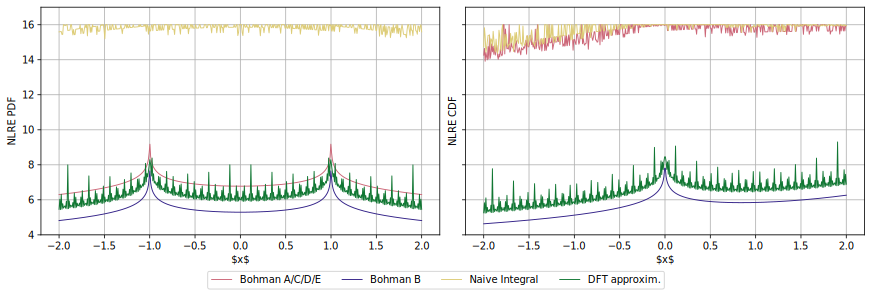

In [15]:
titles = [r"\$\mathcal{N}(0,1)\$"]#, r"\$\mathrm{Laplace}(0,1)\$", r"\$U(0,1)\$", r"\$U^2(0,1)\$"]
for i, case in enumerate(cases):
  if i > 0:
    break
  fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True, layout='constrained') 
  ma = None
  _, ma = plot_distr(case, metrics, methods, axs[0], title = titles[i], ft='pdf', method_association=ma, legend=True)
  _, ma = plot_distr(case, metrics, methods, axs[1], title = titles[i], ft='cdf', method_association=ma, legend=False)
  #fig.subplots_adjust(wspace=0.1)  
  fig.legend(loc='outside lower center', ncols=6, )
  # fig.tight_layout()
  fig.savefig(f'plots/{case['name']}_lre_distr.svg')